<a href="https://colab.research.google.com/github/Hramchenko/Handwritting/blob/master/V10_of_EQ_no_prof_simpl_new_proffs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
#device = torch.device("cpu")
print(device)

Device Tesla K80
cuda:0


In [0]:
batch_size = 100

image_width = 1500
image_height = 200

In [0]:
import os
import cv2
from xml.dom import minidom
import matplotlib.pyplot as plt
from math import floor
from random import random
import scipy as sp


class ArtificialHandwrittingObject:
    
    def __init__(self, name, img):
        self.name = name
        self.image = img

class ArtificialHandwritting:
    
    def __init__(self, datasetDir, scale, image_width, image_height, encode_word):
        self.scale = scale
        self.height = image_height
        self.width = image_width
        self.datasetDirectory = datasetDir
        self.data = {}
        self.initOffsets()
        self.encode_word = encode_word
        
        for f_name in os.listdir(datasetDir):
            if not f_name.endswith(".xml"):
                continue
            full_path = datasetDir + f_name
            print(full_path)
            self.process_xml(full_path)
            
    def initOffsets(self):
        self.offsets = {
            'a': 0,
            'b': -0.1,
            'c': 0,
            'd': 0,
            'e': 0,
            'f': -0.2,
            'g': +0.3,
            'h': 0,
            'i': -0.15,
            'j': +0.2,
            'k': 0,
            'l': -0.15,
            'm': 0,
            'n': 0,
            'o': 0,
            'p': 0,
            'q': +0.2,
            'r': 0,
            's': 0,
            't': -0.2,
            'u': 0,
            'v': 0,
            'w': 0,
            'x': 0,
            'y': +0.2,
            'z': 0,
        }
        
        
        
    def getValue(self, node, name):
        v  = node.getElementsByTagName(name) 
        if len(v) != 1:
            raise Exception()
        v = v[0].firstChild.data
        return v
    
    def make_random_batch(self, word_len, rand_x):
        alphabet = "abcdefghijklmnopqrstuvwxyz"
        texts = []
        datas = []
        #data = torch.FloatTensor(batch_size, self.image_height, self.image_width)
        for batch_idx in range(0, batch_size):
          w = ""
          for i in range(0, word_len):
            s_idx = floor(random()*len(alphabet))
            s = alphabet[s_idx]
            w += s
          x = floor(random()*rand_x)
          d, _ = self.make_word(w, x)
          d = d = torch.as_tensor(d)#.unsqueeze(0)
          
          datas.append(d)
          w = self.encode_word(w)
          texts.append(w)
        t = torch.stack(texts)
        data = torch.stack(datas, dim=0)
        return data, t
          
       
    def make_word(self, word, x_start):
        center = self.height*0.5
        result = sp.ones([self.height, self.width], dtype="float32")
        candidates = []
        for k in self.data.keys():
            d = self.data[k]
            flag = True
            for s in word:
                if s not in d:
                    flag = False
                    break
            if flag:
                candidates.append(k)
        idx = floor(random()*len(candidates))
        if (len(candidates) == 0):
          print("Bad word: " + word)
          raise Exception()
        
        img_file = candidates[idx]
        page = self.data[img_file]
        x = x_start
        for s in word:
            s_idx = floor(len(page[s])*random())
            obj_im = page[s][s_idx].image
            c = 0.5*obj_im.shape[0]
            dy = 0 + floor(center - c + obj_im.shape[0]*(self.offsets[s]+random()*0.05))#+random()*0.05))
            #print(dy)
            #print(obj_im.dtype)
            result[dy: dy + obj_im.shape[0], x: x+obj_im.shape[1]] = obj_im
            x += obj_im.shape[1]
        return result, img_file  
      
            
    def process_xml(self, f_path):
        
        xml_file = minidom.parse(f_path)
        #xml_file.normalize()
        annotation = xml_file.getElementsByTagName('annotation')
        if len(annotation) != 1:
            raise Exception()
        annotation = annotation[0]
        img_name = self.getValue(annotation, 'filename')
        image_file = self.datasetDirectory + img_name
        img = cv2.imread(image_file, 0)
        print(image_file)
        objects = annotation.getElementsByTagName('object')
        #print(len(objects))
        content = {}
        for obj in objects:
            name  = self.getValue(obj, 'name')
            if name not in content:
                content[name] = []
            x_min = int(self.getValue(obj, 'xmin'))
            y_min = int(self.getValue(obj, 'ymin'))
            x_max = int(self.getValue(obj, 'xmax'))
            y_max = int(self.getValue(obj, 'ymax'))
            obj_im = img[y_min: y_max, x_min: x_max]
            s = self.scale
            sh = obj_im.shape
            obj_im = cv2.resize(obj_im, (floor(sh[1]*s), floor(sh[0]*s)), cv2.INTER_LANCZOS4)
            if obj_im.shape[0] > self.height:
                continue
            obj_im = sp.float32(obj_im)    
            obj_im = (obj_im - obj_im.min())/(obj_im.max() - obj_im.min())
            handwr_obj = ArtificialHandwrittingObject(name, obj_im)
            content[name].append(handwr_obj)
        if img_name in self.data:
            raise Exception()
        self.data[img_name] = content
        

In [4]:
import sys
sys.path.append("./Handwritting/")
from IAMWords import IAMWords

pad_length=-1
train_set = IAMWords("train", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=400)
test_set = IAMWords("test", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=400)

Reading ./IAM/words.train.pkl...
Reading finished
Reading ./IAM/words.test.pkl...
Reading finished


In [5]:
artificial_data = ArtificialHandwritting("./MyLetters/", 1.0, image_width, image_height, train_set.encode_word)
data, target = artificial_data.make_random_batch(3, 400)

./MyLetters/a01-107u.xml
./MyLetters/a01-107u.png
./MyLetters/my.xml
./MyLetters/my.jpg
./MyLetters/a01-053u.xml
./MyLetters/a01-053u.png
./MyLetters/a01-128.xml
./MyLetters/a01-128.png
./MyLetters/a01-107.xml
./MyLetters/a01-107.png
./MyLetters/a01-026u.xml
./MyLetters/a01-026u.png


In [6]:
artificial_data.data["my.jpg"].keys()

dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 't', 'v', 'w', 'x', 'y', 'z', 'j'])

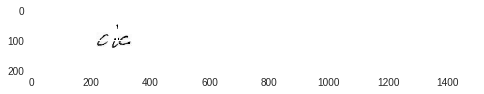

torch.Size([100, 200, 1500])

In [7]:
plt.imshow(data[0], cmap="gray")
plt.show()
data.shape

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
from Layers import *
from HTREncoder import *
from HTRDecoder import *
from HTRDiscriminator import *

In [0]:
batch = train_set.make_batch(use_binarization=False)
data, target = batch
target = target.to(device)
data = data/255.0
data = data.view(batch_size, 1, image_width, image_height).to(device)

In [0]:

encoder = HTREncoder().to(device)

In [12]:
c = encoder(data)
c.shape

torch.Size([100, 64, 9, 11])

In [0]:
def to_onehot(x, n):
    one_hot = torch.zeros((x.shape[0], n)).to(device)
    one_hot.scatter_(1, x[:, None], 1.)
    if device is not None:
        one_hot = one_hot.to(device)
    return one_hot  

In [0]:
class HTRDecoderResult:
  
  def __init__(self):
    None

class HTRDecoder(nn.Module):
    def __init__(self, batch_size, ntoken, encoded_width=92, encoded_height=64, batchnorm=False, dropout=True, rnn_type="LSTM"):
        super(HTRDecoder, self).__init__()
        self.batch_size = batch_size
        self.ntoken = ntoken
        self.encoded_width = encoded_width
        self.encoded_height = encoded_height
        self.lstm_size = 256
        self.lstm_layers = 2
        self.rnn_type = rnn_type
        self.emb_size = 128
        features_size = self.encoded_height*encoded_width + self.emb_size
        from math import floor
        lstm_inp_size = features_size
        
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        else:
            self.rnn = nn.GRU(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        self.embedding = nn.Embedding(ntoken, self.emb_size)
        self.decoder = nn.Linear(1*self.lstm_size*1, ntoken)#*batch_size)
        self.drop = nn.Dropout(0.3)

        self.attention = FullyConnectedX([self.lstm_size*2 + self.encoded_height*encoded_width, self.encoded_height*encoded_width*2,  self.encoded_width], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
        self.attention_weights = None
    
    def forward(self, x, prev, hidden=None):
        x = self.drop(x).squeeze()
        if hidden is not None:
            hidden_m = hidden.permute(1, 0, 2)
            hidden_m = hidden_m.flatten(start_dim=1)
            #print(x.shape)
            #print(hidden_m.shape)
            x_m = x.flatten(start_dim=1)
            attention_inp = torch.cat([x_m, hidden_m], dim=1).detach()
            self.attention_weights = self.attention(attention_inp)
            self.attention_weights = F.softmax(self.attention_weights, dim=1).unsqueeze(1)
            #print("iiiif")
            #print(self.attention_weights.shape)
            
            self.attention_weights = self.attention_weights.repeat([1, self.encoded_height, 1])
            #print("fffff")
            #print(x.shape)
            #print(self.attention_weights.shape)
            x = x * self.attention_weights
        emb = self.embedding(prev).squeeze().detach()
        x = torch.cat([x.flatten(start_dim=1), emb], dim=1)
        x = x.unsqueeze(0)
        result = HTRDecoderResult()
        result.rnn_input = x
        result.input_hidden = hidden
        x, hidden = self.rnn(x, hidden)
        x = x.squeeze(dim=0)
        x = self.drop(x)
        x = self.decoder(x)
        x = F.log_softmax(x, dim=1)
        result.x = x
        result.hidden = hidden
        return result
      
    def makeHidden(self):
        if self.rnn_type == "LSTM":
            h1 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            h2 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            return (h1, h2)
        else:
            h1 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            return h1


decoder = HTRDecoder(batch_size, len(train_set.codes), rnn_type="GRU").to(device)

In [0]:
START = train_set.codes['<START>']
current_symbol = torch.LongTensor(batch_size, 1).to(device)
current_symbol[:, :] = START

In [0]:
def test(max_size):
  print("Testing...")
  
  freq = 20
  
  test_set.to_start(max_size, equalize_freq=True)
  batch_idx = 0
  c_loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  recognition_result.fill_(START)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  
  test_loss = 0
  
  with torch.no_grad():  
    while True:
      batch = test_set.make_batch()
      if batch is None:
        break

      if True:
        l = 1 + floor((max_size - 1)*random())
        data, target = artificial_data.make_random_batch(l, 200)
        orig_data = data*255;
        data = data.unsqueeze(1).to(device)
        target = target.to(device)  
      else:  
        orig_data, target = batch
        data = orig_data/255.0
        #data = data.view(batch_size, 1, image_width, image_height).to(device)
        data = data.unsqueeze(1).to(device)
        target = target.to(device)
      hidden = decoder.makeHidden().to(device)    

      loss = 0
      enc = encoder(data)
      #print(enc.shape)
      s = enc
      #print(s.shape)
      #s = s.flatten(start_dim=1).view(1, batch_size, -1)

      old_symbol[:, 0] = START

      for i in range(0, target.shape[1]):

        decoder_result = decoder(s, old_symbol, hidden)
        dec = decoder_result.x
        hidden = decoder_result.hidden

        recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
        old_symbol[:, 0] = target[:, i]

        loss += criterion(dec, target[:, i])
      c_loss += loss.item()/(target.shape[1] + 0)
      test_loss += loss.item()/(target.shape[1] + 0)
      if (batch_idx % freq == 0) and (batch_idx != 0):
        if True:#not use_teacher_forcing:
          print(target.shape[0])
          for k in range(0, min(3, target.shape[0])):
              decoded = recognition_result[k,0:target.shape[1] + 1]
              plt.imshow(orig_data[k].cpu(), cmap="gray")
              plt.show()
              print("  '" + train_set.decode_word(target[k,:]) + "' -> '" + train_set.decode_word(decoded) + "'")
        c_loss /= freq 
        print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
        c_loss = 0
      batch_idx += 1  
  print("Test loss: %f" % (test_loss/batch_idx))   

In [0]:
discriminator = HTRDiscriminator(batch_size, 256*2, 512, 10, len(train_set.codes)).to(device)      

In [0]:
def apply_discriminator(s, target, use_teacher_forcing, train_mode, discriminator_target):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  train_mask = torch.ByteTensor(batch_size).to(device)
  train_mask[:] = 1

  hidden = decoder.makeHidden().to(device)    
  discriminator_loss = 0
  discriminator_hidden = discriminator.makeHidden().to(device)

  for i in range(0, target.shape[1] + 1):

    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    decoder_outputs = dec.topk(1, dim=1)[1].flatten()

    
    if train_mode:
      dl, discriminator_hidden = discriminator.apply(discriminator_hidden.detach(), decoder_result.input_hidden.detach(),decoder_result.rnn_input.detach(), decoder_outputs.detach(), discriminator_target)
    else:
      dl, discriminator_hidden = discriminator.apply(discriminator_hidden, decoder_result.input_hidden, decoder_result.rnn_input, decoder_outputs, discriminator_target)
      
    if i != 0:
      discriminator_loss += dl

    recognition_result[:, i] = decoder_outputs.detach()
    
    if i == target.shape[1]:
      target_symbol = stop_symbol[:, 0]
    else:
      target_symbol = target[:, i]    
    
    if use_teacher_forcing:
      old_symbol[:, 0] = target_symbol
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    #import pdb; pdb.set_trace()

    loss += criterion(dec, target_symbol)
 
  discriminator_loss /= target.shape[1]
  return (recognition_result, loss, discriminator_loss)

In [0]:
def apply_decoder(s, target, use_teacher_forcing):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  recognition_result.fill_(START)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  hidden = decoder.makeHidden().to(device)  
  
  for i in range(0, target.shape[1] + 1):

    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
    
    if i == target.shape[1]:
      target_symbol = stop_symbol[:, 0]
    else:
      target_symbol = target[:, i]
    
    if use_teacher_forcing:
      old_symbol[:, 0] = target_symbol
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    #import pdb; pdb.set_trace()

    loss += criterion(dec, target_symbol)
  return (recognition_result, loss)


batch_zeros = torch.zeros(batch_size, 1).to(device)
batch_ones = torch.ones(batch_size, 1).to(device)

In [0]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=0.00005)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, weight_decay=0.00005)

criterion = nn.NLLLoss()

teacher_forcing_ratio = 1#0.5

from random import random

def train(epoch, max_size):
  print("Training epoch " + str(epoch) + "...")
  
  freq = 30
  
  train_set.to_start(max_size, equalize_freq=True)
  batch_idx = 0
  c_loss = 0

  
  train_loss = 0
  discr_applied = 0
  
  while True:
    if batch_idx > 400:
      break
    if True:
      l = 1 + floor((max_size - 1)*random())
      data, target = artificial_data.make_random_batch(l, 200)
      data = data.unsqueeze(1).to(device)
      target = target.to(device)
    else:
      batch = train_set.make_batch()
      if batch is None:
        break
      orig_data, target = batch
      data = orig_data/255.0
      #data = data.view(batch_size, 1, image_width, image_height).to(device)
      data = data.unsqueeze(1).to(device)
      target = target.to(device)


    encoder.zero_grad()
    decoder.zero_grad()

    
    enc = encoder(data)
    #print(enc.shape)
    s = enc
    #s = enc.permute(1, 0, 2)
    #s = s.squeeze(0)
    #print(s.shape)
    #print(s.shape)
    #s = s.flatten(start_dim=1).view(1, batch_size, -1)
    #s = s.flatten(start_dim=1).squeeze(0)
    s = s.unsqueeze(0)
    #print(s.shape)
    
    discr_loss = 1
    if False: #True#target.shape[1] > 1:
      discriminator_optimizer.zero_grad()
      _, _, tf_loss = apply_discriminator(s, target, True, True, batch_ones)
      _, _, fr_loss = apply_discriminator(s, target, False, True, batch_zeros)
      dl = tf_loss + fr_loss
      discr_loss = dl.item()
      if (batch_idx % freq == 0) and (batch_idx != 0):
        print("Discr loss: %f" %(dl.item()))
      #print(dl)
      dl.backward()
      discriminator_optimizer.step()
   

      #     use_teacher_forcing = True if random() < teacher_forcing_ratio else False
      # #    recognition_result, loss, discriminator_loss = apply_discriminator(s, target, use_teacher_forcing, True, batch_zeros)
      #     recognition_result, loss = apply_decoder(s, target, use_teacher_forcing)
    batch_loss = None  
    if False:#discr_loss < 0.3:
      discriminator_optimizer.zero_grad()
      recognition_result, loss, discriminator_loss = apply_discriminator(s, target, True, False, batch_zeros)
      batch_loss = loss.item()
      loss = loss + discriminator_loss
      discr_applied += 1
      #print("Apply descr...")
    else:
      recognition_result, loss = apply_decoder(s, target, True)
      batch_loss = loss.item()

      
      
    c_loss += batch_loss/(target.shape[1] + 0)
    train_loss += batch_loss/(target.shape[1] + 0)
    if (batch_idx % freq == 0) and (batch_idx != 0):
      
      if False:#True:#not use_teacher_forcing:
        for k in range(0, min(3, target.shape[0])):
            decoded = recognition_result[k,0:target.shape[1] + 1]
            plt.imshow(orig_data[k].cpu(), cmap="gray")
            plt.show()
            print("  '" + train_set.decode_word(target[k,:]) + "' -> '" + train_set.decode_word(decoded) + "'")
      c_loss /= freq 
      print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
      c_loss = 0
    loss.backward()
    #grad_clip = 0.1
    #torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
    #torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    batch_idx += 1
  print("Train loss: %f"%(train_loss/batch_idx))
  print("Discr applied %d times."%discr_applied)



In [0]:
file_name = "/gdrive/My Drive/v9.tar"

In [0]:
# state = torch.load(file_name)
# encoder.load_state_dict(state["encoder"])
# encoder_optimizer.load_state_dict(state["encoder_optimizer"])
# decoder.load_state_dict(state["decoder"])
# decoder_optimizer.load_state_dict(state["decoder_optimizer"])
# discriminator.load_state_dict(state["discriminator"])
# discriminator_optimizer.load_state_dict(state["discriminator_optimizer"])

Training epoch 0...
  Batch: 30 Loss: 4.632001662254334
  Batch: 60 Loss: 4.074227436383565
  Batch: 90 Loss: 4.165116874376933
  Batch: 120 Loss: 3.795614512761434
  Batch: 150 Loss: 3.8198868592580157
  Batch: 180 Loss: 3.8868839661280314
  Batch: 210 Loss: 3.8398034652074178
  Batch: 240 Loss: 3.8244423548380535
  Batch: 270 Loss: 3.8766579389572144
  Batch: 300 Loss: 3.839652442932129
  Batch: 330 Loss: 3.770974079767863
  Batch: 360 Loss: 3.869060413042704
  Batch: 390 Loss: 3.832392382621765
Train loss: 3.926000
Discr applied 0 times.
Testing...
100


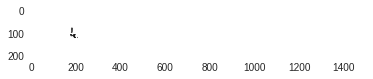

  'k' -> 'l<STOP>'


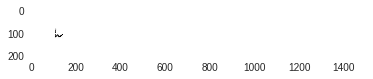

  'w' -> 'h<STOP>'


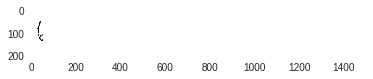

  'b' -> 'q<STOP>'
  Batch: 20 Loss: 3.6216557741165163
Test loss: 3.440756
Training epoch 1...
  Batch: 30 Loss: 4.016778039932251
  Batch: 60 Loss: 3.79669238726298
  Batch: 90 Loss: 3.84801496664683
  Batch: 120 Loss: 3.8561603864034018
  Batch: 150 Loss: 3.839864452679952
  Batch: 180 Loss: 3.849694506327311
  Batch: 210 Loss: 3.8042221387227375
  Batch: 240 Loss: 3.832104762395223
  Batch: 270 Loss: 3.8296783367792764
  Batch: 300 Loss: 3.798461167017619
  Batch: 330 Loss: 3.799392739931742
  Batch: 360 Loss: 3.90556636651357
  Batch: 390 Loss: 3.840404470761617
Train loss: 3.836014
Discr applied 0 times.
Testing...
100


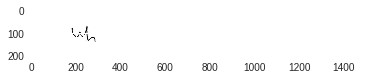

  'uh' -> 'j<STOP><START>'


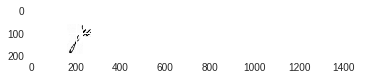

  'ju' -> 'j<STOP><START>'


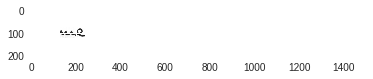

  'me' -> 'p<STOP><START>'
  Batch: 20 Loss: 3.6457294702529905
Test loss: 3.459789
Training epoch 2...
  Batch: 30 Loss: 3.9700570424397785
  Batch: 60 Loss: 3.873997203509013
  Batch: 90 Loss: 3.810282413164775
  Batch: 120 Loss: 3.8945321321487425
  Batch: 150 Loss: 3.820271356900533
  Batch: 180 Loss: 3.8144075234731036
  Batch: 210 Loss: 3.8666647990544636
  Batch: 240 Loss: 3.79081768989563
  Batch: 270 Loss: 3.840368946393331
  Batch: 300 Loss: 3.806581211090088
  Batch: 330 Loss: 3.804301937421163
  Batch: 360 Loss: 3.8104432106018065
  Batch: 390 Loss: 3.829403114318848
Train loss: 3.830160
Discr applied 0 times.
Testing...
100


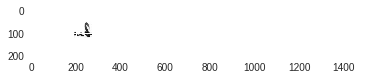

  'nf' -> 'r<STOP><START>'


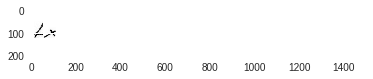

  'tx' -> 'w<STOP><START>'


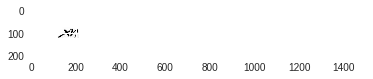

  'xn' -> 't<STOP><START>'
  Batch: 20 Loss: 3.6493435978889464
Test loss: 3.471519
Training epoch 3...
  Batch: 30 Loss: 3.9234810988108317
  Batch: 60 Loss: 3.8046159982681274
  Batch: 90 Loss: 3.8935221910476683
  Batch: 120 Loss: 3.7913564523061116
  Batch: 150 Loss: 3.9001400152842205
  Batch: 180 Loss: 3.7838345925013224
  Batch: 210 Loss: 3.8556677103042603
  Batch: 240 Loss: 3.7850757439931235
  Batch: 270 Loss: 3.7999388138453165
  Batch: 300 Loss: 3.892294406890869
  Batch: 330 Loss: 3.8013043483098348
  Batch: 360 Loss: 3.8044825315475466
  Batch: 390 Loss: 3.8376365900039673
Train loss: 3.828213
Discr applied 0 times.
Testing...
100


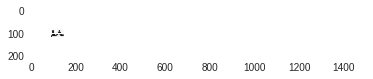

  'u' -> 'l<STOP>'


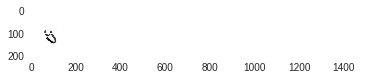

  'y' -> 'l<STOP>'


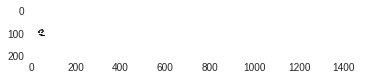

  'e' -> 'e<STOP>'
  Batch: 20 Loss: 3.60245521068573
Test loss: 3.446907
Training epoch 4...
  Batch: 30 Loss: 3.951994760831197
  Batch: 60 Loss: 3.8530160824457806
  Batch: 90 Loss: 3.800746122996012
  Batch: 120 Loss: 3.8079922596613565
  Batch: 150 Loss: 3.84322882493337
  Batch: 180 Loss: 3.7743430773417157
  Batch: 210 Loss: 3.884132973353068
  Batch: 240 Loss: 3.827264602979024
  Batch: 270 Loss: 3.7760066747665406
  Batch: 300 Loss: 3.926971181233724
  Batch: 330 Loss: 3.793232003847758
  Batch: 360 Loss: 3.828239432970683
  Batch: 390 Loss: 3.748445653915405
Train loss: 3.826661
Discr applied 0 times.
Testing...
100


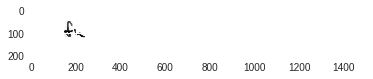

  'fh' -> 'i<STOP><START>'


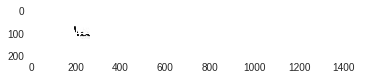

  'ln' -> 'x<STOP><START>'


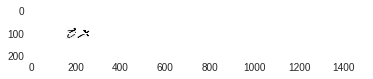

  'ox' -> 'o<STOP><START>'
  Batch: 20 Loss: 3.5792180776596068
Test loss: 3.407136
Training epoch 5...
  Batch: 30 Loss: 3.9714412689208984
  Batch: 60 Loss: 3.812196667989095
  Batch: 90 Loss: 3.79758243560791
  Batch: 120 Loss: 3.8286513884862265
  Batch: 150 Loss: 3.8370676755905153
  Batch: 180 Loss: 3.869170300165812
  Batch: 210 Loss: 3.8024051268895467
  Batch: 240 Loss: 3.7987411975860597
  Batch: 270 Loss: 3.8435128132502236
  Batch: 300 Loss: 3.830060338973999
  Batch: 330 Loss: 3.7982443968454995
  Batch: 360 Loss: 3.8180343389511107
  Batch: 390 Loss: 3.839800461133321
Train loss: 3.824611
Discr applied 0 times.
Testing...
100


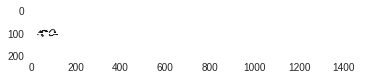

  'ra' -> 's<STOP><START>'


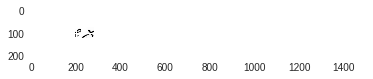

  'ex' -> 'i<STOP><START>'


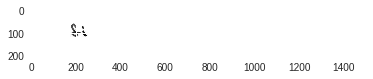

  'fi' -> 'i<STOP><START>'
  Batch: 20 Loss: 3.60460946559906
Test loss: 3.442202
Training epoch 6...
  Batch: 30 Loss: 3.9534399429957072
  Batch: 60 Loss: 3.7591006914774576
  Batch: 90 Loss: 3.915622433026632
  Batch: 120 Loss: 3.8331894238789874
  Batch: 150 Loss: 3.7720100402832033
  Batch: 180 Loss: 3.823093843460083
  Batch: 210 Loss: 3.8807232697804768
  Batch: 240 Loss: 3.7725671847661335
  Batch: 270 Loss: 3.830880379676819
  Batch: 300 Loss: 3.8428167502085366
  Batch: 330 Loss: 3.7696316401163736
  Batch: 360 Loss: 3.797982692718506
  Batch: 390 Loss: 3.8736989895502725
Train loss: 3.822404
Discr applied 0 times.
Testing...
100


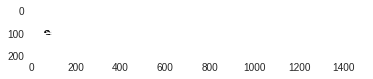

  'o' -> 'g<STOP>'


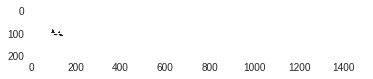

  'h' -> 'l<STOP>'


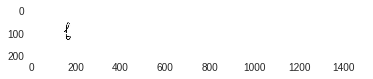

  'b' -> 'g<STOP>'
  Batch: 20 Loss: 3.6011261701583863
Test loss: 3.423278
Training epoch 7...
  Batch: 30 Loss: 3.971552077929179
  Batch: 60 Loss: 3.8143961906433104
  Batch: 90 Loss: 3.7924916982650756
  Batch: 120 Loss: 3.869324819246928
  Batch: 150 Loss: 3.7982232332229615
  Batch: 180 Loss: 3.807166854540507
  Batch: 210 Loss: 3.8281251112620036
  Batch: 240 Loss: 3.813085699081421
  Batch: 270 Loss: 3.7655693372090657
  Batch: 300 Loss: 3.926546057065328
  Batch: 330 Loss: 3.7941741069157917
  Batch: 360 Loss: 3.773686408996582
  Batch: 390 Loss: 3.943391482035319
Train loss: 3.826306
Discr applied 0 times.
Testing...
100


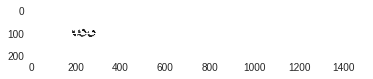

  'wv' -> 'c<STOP><START>'


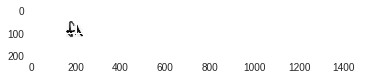

  'fl' -> 'h<STOP><START>'


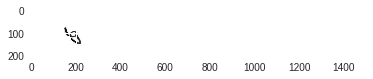

  'lg' -> 'v<STOP><START>'
  Batch: 20 Loss: 3.7236720085144044
Test loss: 3.517080
Training epoch 8...
  Batch: 30 Loss: 3.883336551984151
  Batch: 60 Loss: 3.8338311751683554
  Batch: 90 Loss: 3.8156977256139117
  Batch: 120 Loss: 3.7571914037068685
  Batch: 150 Loss: 3.9211201588312785
  Batch: 180 Loss: 3.772449588775635
  Batch: 210 Loss: 3.8024672269821167
  Batch: 240 Loss: 3.8515376329421995
  Batch: 270 Loss: 3.790012009938558
  Batch: 300 Loss: 3.801616668701172
  Batch: 330 Loss: 3.8219838460286457
  Batch: 360 Loss: 3.795621919631958
  Batch: 390 Loss: 3.7903853178024294
Train loss: 3.806775
Discr applied 0 times.
Testing...
100


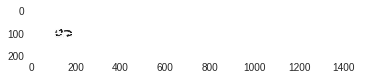

  'vs' -> 'v<STOP><START>'


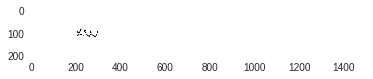

  'xw' -> 'j<STOP><START>'


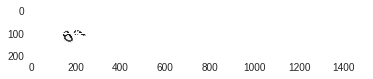

  'ga' -> 'a<STOP><START>'
  Batch: 20 Loss: 3.5879841566085817
Test loss: 3.400005
Training epoch 9...
  Batch: 30 Loss: 3.9664684851964314
  Batch: 60 Loss: 3.8495391845703124
  Batch: 90 Loss: 3.7905778964360555
  Batch: 120 Loss: 3.7984088182449343
  Batch: 150 Loss: 3.7606834252675374
  Batch: 180 Loss: 3.805359411239624
  Batch: 210 Loss: 3.7930187066396077
  Batch: 240 Loss: 3.7741039673487347
  Batch: 270 Loss: 3.9017576853434246
  Batch: 300 Loss: 3.793397649129232
  Batch: 330 Loss: 3.853046456972758
  Batch: 360 Loss: 3.8252675692240397
  Batch: 390 Loss: 3.7746009826660156
Train loss: 3.811396
Discr applied 0 times.
Testing...
100


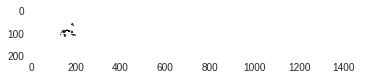

  'ri' -> 'x<STOP><START>'


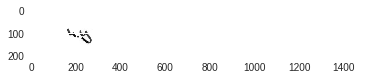

  'hy' -> 's<STOP><START>'


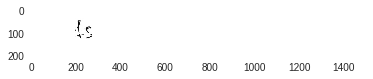

  'fs' -> 'q<STOP><START>'
  Batch: 20 Loss: 3.59916615486145
Test loss: 3.416939
Training epoch 10...
  Batch: 30 Loss: 3.928108485539754
  Batch: 60 Loss: 3.8527167558670046
  Batch: 90 Loss: 3.7962196270624795
  Batch: 120 Loss: 3.784746026992798
  Batch: 150 Loss: 3.8058751821517944
  Batch: 180 Loss: 3.7872671206792194
  Batch: 210 Loss: 3.836822493871053
  Batch: 240 Loss: 3.7972137053807575
  Batch: 270 Loss: 3.8532200972239177
  Batch: 300 Loss: 3.8025853554407756
  Batch: 330 Loss: 3.7878450552622476
  Batch: 360 Loss: 3.813705237706502
  Batch: 390 Loss: 3.798711554209391
Train loss: 3.809153
Discr applied 0 times.
Testing...
100


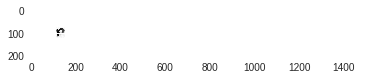

  'p' -> 'e<STOP>'


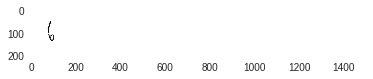

  'b' -> 'a<STOP>'


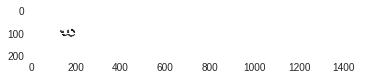

  'w' -> 'd<STOP>'
  Batch: 20 Loss: 3.5987005472183227
Test loss: 3.470284
Training epoch 11...
  Batch: 30 Loss: 3.8880348046620687
  Batch: 60 Loss: 3.7683401902516684


KeyboardInterrupt: ignored

In [29]:
for i in range(0, 100):
  max_size = 3
  train(i, max_size)
  test(max_size)

In [0]:
# state_dict = {
#         "encoder": encoder.state_dict(),
#         "encoder_optimizer": encoder_optimizer.state_dict(),
#         "decoder": decoder.state_dict(),
#         "decoder_optimizer": decoder_optimizer.state_dict(),
#         "discriminator": discriminator.state_dict(),
#         "discriminator_optimizer": discriminator_optimizer.state_dict(),
#       }

# torch.save(state_dict, file_name)


In [28]:
test(2)

Testing...
Test loss: 3.286441


In [0]:
data, target = artificial_data.make_random_batch(3, 200)

In [0]:
for i in range(0, 30):
  plt.imshow(data[i])
  plt.show()
  print(test_set.decode_word(target[i]))